In [15]:
import ee
import geemap
ee.Initialize()

In [16]:
import requests
import pandas as pd
import json
import time

In [17]:
GEOCODE = '4318309'
url = f'http://servicodados.ibge.gov.br/api/v3/malhas/municipios/{GEOCODE}?formato=application/vnd.geo+json'
response = requests.get(url)
geo = response.json();
ee_object = geemap.geojson_to_ee(geo)
geometry = ee_object.geometry()

In [2]:
Map = geemap.Map(center=[-11.77,-45.76], zoom=8)

# Define a region in which to generate a sample of the input.
region = geometry = ee.Geometry.Polygon(
        [[[-46.31633300781251, -12.379228237680417],
          [-45.31108398437501, -12.298734131305821],
          [-45.30009765625001, -11.589339623793398],
          [-46.33830566406251, -11.605482676116234]]])

Map

#Draw the region polygon

Map(center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [35]:
Map.draw_features
roi = ee.FeatureCollection(Map.draw_features)
geometry = roi.geometry()
Map

Map(bottom=35226.0, center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [13]:
Map.addLayer(ee_object)
Map

Map(bottom=35226.0, center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

In [18]:
def clusterization(image):

          
    # Load a pre-computed Landsat composite for input.
    input = image.clip(geometry).select("EVI");
  
    #Make the training dataset.
    training = input.sample(**{
    'region': geometry,
    'scale': 250,
    'numPixels': 5000
    });

    #Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(5).train(training)
    #Cluster the input using the trained clusterer.
    result = input.cluster(clusterer)
 
    #Combine the mean and standard deviation reducers.
    reducers = ee.Reducer.mean()

    #Inicialização Lista de EVI dos clustes
    lista = ee.List([])

    #Iteração sobre os 5 Clusters para calcular a estatística de cada região
    for i in range(5):

        #Cálculo da geometria
        geom = result.select("cluster").eq(i).selfMask().reduceToVectors(**{
        'scale':250,
        });



        #Reducer para cálculo do EVI médio de cada cluster
        stats = image.reduceRegion(**{
        'reducer': reducers,
        'geometry':geom.geometry(),
        'scale':250,
        'bestEffort':True,
        'maxPixels':10000000000,
        });

        #Armarzena o EVI médio de cada clúster em uma lista
        lista = lista.add(stats.get("EVI"));


    #Cópia da Lista para ordenar os 2 maiores EVIs
    lista2 = lista;


    #Ordenar a lista para pegar os 2 maiores valores de EVI médio nos clusters
    #Agora nossos clustests de interesse estão nas posições 3 e 4 da lista 2
    lista2 = lista2.sort()

    #Pegar as chaves dos clusteres de interesse na lista original
    chaves1 = lista.indexOf(lista2.get(3))
    chaves2 = lista.indexOf(lista2.get(4))


    #Cálculo da Geometria final

    geom1 = result.select("cluster").eq(chaves1).selfMask().reduceToVectors(**{
    'scale':250,
    });

    geom2 = result.select("cluster").eq(chaves2).selfMask().reduceToVectors(**{
    'scale':250,
    });

    #Geom é a feature collection de nossos clusters de interesse
    geom = geom1.merge(geom2);



    stats = image.reduceRegion(**{
    'reducer': reducers,
    'geometry':geom.geometry(),
    'scale':250,
    'bestEffort':True,
    'maxPixels':10000000000,
    });


    return image.set('EVI_Cluster', stats.get("EVI"))
    

In [19]:
import requests
import pandas as pd
import json
import time
#import os

#out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')


In [20]:
stats = list();

In [23]:
#Dividir o processamento das imagens de acordo com o ano para não sobrecarregar o sistema
ano = list(range(2008, 2022))

string_ints = [str(int) for int in ano]
#stats = list();
    
for i in (string_ints):
    
    print (i)
    #Filtrar a territorialidade 
    #4 principais meses de safra
    #filter start and end date   
    mcollection = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( i + '-01-01', i +'-04-30').filter(ee.Filter.calendarRange(1, 4,'month')).map(clusterization)
        
    #Pegar a propriedade que nos interessa em cada imagem - o EVI_Cluster Calculado 
    a = mcollection.aggregate_array('EVI_Cluster')
    
    
    #10s de soneca pra o GEE não derrubar as requests
    time.sleep(10)
    # Fazer a informação passar do servidor do google para o jupyter
    x = a.getInfo()
    #Salvar cada ano
    stats.append(x)    
    

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [24]:
stats

[[4971.806516853932,
  5222.343489592893,
  4915.047416324134,
  5058.352198467124,
  4635.440271161598],
 [5192.365960596743,
  5188.040249842157,
  6071.78013763645,
  5571.855578497161,
  5578.360892433566,
  5122.392541840438,
  4378.124269364041,
  4338.41267272964],
 [4510.597121763855,
  4227.7721019457385,
  4890.894374368379,
  5048.090620709247,
  5387.602368010786,
  5424.738267355135,
  4960.740957760729,
  4648.477434425206],
 [4967.225975070366,
  4816.3495608243875,
  5498.696972413999,
  5181.908233379543,
  5268.606797416744,
  5353.716395691643,
  4746.309658902748,
  4097.400216640964],
 [4722.835378909535,
  4926.472674653385,
  5321.466716986557,
  5086.254126905161,
  5296.961154836604,
  4548.647614783863,
  3972.6415496911845,
  3792.6298042223025],
 [4888.99107052939,
  4620.887699153151,
  5590.669700398485,
  5345.38735115939,
  4941.415750796645,
  5114.047684706423,
  4523.36154475823,
  4284.5881512368815],
 [4878.55337464287,
  5586.968243107265,
  5504.7

In [25]:
df = pd.DataFrame({'lin':stats})

In [26]:
#Separate comma
#df = df.apply(lambda x:pd.Series(x))

In [27]:
df = pd.DataFrame(stats, columns = ['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8'])

In [28]:
df

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,4971.806517,5222.343490,4915.047416,5058.352198,4635.440271,NaN,NaN,NaN
1,5192.365961,5188.040250,6071.780138,5571.855578,5578.360892,5122.392542,4378.124269,4338.412673
2,4510.597122,4227.772102,4890.894374,5048.090621,5387.602368,5424.738267,4960.740958,4648.477434
3,4967.225975,4816.349561,5498.696972,5181.908233,5268.606797,5353.716396,4746.309659,4097.400217
4,4722.835379,4926.472675,5321.466717,5086.254127,5296.961155,4548.647615,3972.641550,3792.629804
5,4888.991071,4620.887699,5590.669700,5345.387351,4941.415751,5114.047685,4523.361545,4284.588151
6,4878.553375,5586.968243,5504.763660,5506.861048,5203.050349,4901.016483,4082.125751,3884.381189
7,5314.785534,5682.011870,5839.230305,5624.904408,5165.882279,5015.716416,4533.438037,4568.075307
8,4731.780237,5145.387226,5205.523987,5317.335592,5338.348799,5254.200684,4187.713003,4075.104581
9,4503.278043,4859.154623,5068.144849,6236.117674,5800.336785,5119.630817,4646.240214,3900.657591


In [29]:
#Reshape da 1a linha - Imagens do MODIS a partir de Mar/2000
new_order =  ['EVI6', 'EVI7', 'EVI8','EVI1','EVI2','EVI3','EVI4','EVI5'] # specify new order of the third row
i = 0 # specify row number
df.loc[0] = df.loc[0, new_order].values

In [30]:
#Corrigir os Nans
#Features dos EVIS pronta
df.fillna(0)


,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,0.000000,0.000000,0.000000,4971.806517,5222.343490,4915.047416,5058.352198,4635.440271
1,5192.365961,5188.040250,6071.780138,5571.855578,5578.360892,5122.392542,4378.124269,4338.412673
2,4510.597122,4227.772102,4890.894374,5048.090621,5387.602368,5424.738267,4960.740958,4648.477434
3,4967.225975,4816.349561,5498.696972,5181.908233,5268.606797,5353.716396,4746.309659,4097.400217
4,4722.835379,4926.472675,5321.466717,5086.254127,5296.961155,4548.647615,3972.641550,3792.629804
5,4888.991071,4620.887699,5590.669700,5345.387351,4941.415751,5114.047685,4523.361545,4284.588151
6,4878.553375,5586.968243,5504.763660,5506.861048,5203.050349,4901.016483,4082.125751,3884.381189
7,5314.785534,5682.011870,5839.230305,5624.904408,5165.882279,5015.716416,4533.438037,4568.075307
8,4731.780237,5145.387226,5205.523987,5317.335592,5338.348799,5254.200684,4187.713003,4075.104581
9,4503.278043,4859.154623,5068.144849,6236.117674,5800.336785,5119.630817,4646.240214,3900.657591


In [31]:
GEOCODE = '4318309'


In [32]:
url = f'https://apiprevmet3.inmet.gov.br/estacao/proxima/{GEOCODE}'
response = requests.get(url).json()
response

{'estacao': {'UF': 'RS',
  'CODIGO': 'A832',
  'LONGITUDE': '-54.310909',
  'REGIAO': 'S',
  'DISTANCIA_EM_KM': '6',
  'NOME': 'SÃO GABRIEL',
  'LATITUDE': '-30.341438',
  'GEOCODE': '4318309'},
 'dados': {'DC_NOME': 'SÃO GABRIEL',
  'PRE_INS': '1014.2',
  'TEM_SEN': '7',
  'VL_LATITUDE': '-30.341438',
  'PRE_MAX': '1014.2',
  'UF': 'RS',
  'RAD_GLO': '-3.54',
  'PTO_INS': '2.3',
  'TEM_MIN': '5.5',
  'VL_LONGITUDE': '-54.310909',
  'UMD_MIN': '65',
  'PTO_MAX': '2.3',
  'VEN_DIR': '197',
  'DT_MEDICAO': '2021-07-29',
  'CHUVA': '0',
  'PRE_MIN': '1013.9',
  'UMD_MAX': '79',
  'VEN_VEL': '0',
  'PTO_MIN': '1',
  'TEM_MAX': '7.1',
  'VEN_RAJ': '0.7',
  'TEM_INS': '5.5',
  'UMD_INS': '79',
  'CD_ESTACAO': 'A832',
  'HR_MEDICAO': '2300'}}

In [33]:
estacao = response['dados']['CD_ESTACAO']

In [34]:
new_url = f'https://apitempo.inmet.gov.br/estacao/diaria/1999-11-01/2021-04-30/{estacao}'
json_response = requests.get(new_url).json()
dados_estacao = pd.DataFrame(json_response)
dados_estacao

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_MIN,TEMP_MED,CHUVA,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,VEL_VENTO_MED,CD_ESTACAO,VL_LONGITUDE
0,None,1999-11-01,SÃO GABRIEL,None,None,None,-30.341438,None,None,RS,None,A832,-54.310909
1,None,1999-11-02,SÃO GABRIEL,None,None,None,-30.341438,None,None,RS,None,A832,-54.310909
2,None,1999-11-03,SÃO GABRIEL,None,None,None,-30.341438,None,None,RS,None,A832,-54.310909
3,None,1999-11-04,SÃO GABRIEL,None,None,None,-30.341438,None,None,RS,None,A832,-54.310909
4,None,1999-11-05,SÃO GABRIEL,None,None,None,-30.341438,None,None,RS,None,A832,-54.310909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,75.8,2021-04-26,SÃO GABRIEL,43,14.3,0.2,-30.341438,8.6,21.7,RS,1.3,A832,-54.310909
7848,77,2021-04-27,SÃO GABRIEL,48,13.4,0,-30.341438,6.4,21,RS,1.6,A832,-54.310909
7849,76.8,2021-04-28,SÃO GABRIEL,44,13.5,0.2,-30.341438,6,22.3,RS,1.4,A832,-54.310909
7850,75.9,2021-04-29,SÃO GABRIEL,45,14.9,0,-30.341438,8,23.1,RS,1.6,A832,-54.310909


In [35]:
dados_estacao['CHUVA'] = dados_estacao['CHUVA'].astype(float)
dados_estacao['DT_MEDICAO'] = pd.to_datetime(dados_estacao['DT_MEDICAO'])
dados_estacao['ANO'] = dados_estacao['DT_MEDICAO'].dt.year
dados_estacao['MES'] = dados_estacao['DT_MEDICAO'].dt.month
dados_estacao

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_MIN,TEMP_MED,CHUVA,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,VEL_VENTO_MED,CD_ESTACAO,VL_LONGITUDE,ANO,MES
0,None,1999-11-01,SÃO GABRIEL,None,None,NaN,-30.341438,None,None,RS,None,A832,-54.310909,1999,11
1,None,1999-11-02,SÃO GABRIEL,None,None,NaN,-30.341438,None,None,RS,None,A832,-54.310909,1999,11
2,None,1999-11-03,SÃO GABRIEL,None,None,NaN,-30.341438,None,None,RS,None,A832,-54.310909,1999,11
3,None,1999-11-04,SÃO GABRIEL,None,None,NaN,-30.341438,None,None,RS,None,A832,-54.310909,1999,11
4,None,1999-11-05,SÃO GABRIEL,None,None,NaN,-30.341438,None,None,RS,None,A832,-54.310909,1999,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,75.8,2021-04-26,SÃO GABRIEL,43,14.3,0.2,-30.341438,8.6,21.7,RS,1.3,A832,-54.310909,2021,4
7848,77,2021-04-27,SÃO GABRIEL,48,13.4,0.0,-30.341438,6.4,21,RS,1.6,A832,-54.310909,2021,4
7849,76.8,2021-04-28,SÃO GABRIEL,44,13.5,0.2,-30.341438,6,22.3,RS,1.4,A832,-54.310909,2021,4
7850,75.9,2021-04-29,SÃO GABRIEL,45,14.9,0.0,-30.341438,8,23.1,RS,1.6,A832,-54.310909,2021,4


In [36]:
b  = dados_estacao.groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [37]:
mask = (dados_estacao['MES'] <= 4) | (dados_estacao['MES'] >= 11)  
b = dados_estacao.loc[mask].groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [38]:
chuva = b.values.reshape(22,6)
df2 = pd.DataFrame(chuva, columns = ['C_NOV', 'C_DEZ','C_JAN','C_FEV','C_MAR','C_ABR'])
df2

,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,110.8,104.2,30.6,91.8,58.6,108.2
9,61.0,62.4,84.2,208.2,97.8,10.0


In [39]:
concat_data = pd.concat([df,df2],axis=1).fillna(0)

In [40]:
concat_data

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,0.000000,0.000000,0.000000,4971.806517,5222.343490,4915.047416,5058.352198,4635.440271,0.0,0.0,0.0,0.0,0.0,0.0
1,5192.365961,5188.040250,6071.780138,5571.855578,5578.360892,5122.392542,4378.124269,4338.412673,0.0,0.0,0.0,0.0,0.0,0.0
2,4510.597122,4227.772102,4890.894374,5048.090621,5387.602368,5424.738267,4960.740958,4648.477434,0.0,0.0,0.0,0.0,0.0,0.0
3,4967.225975,4816.349561,5498.696972,5181.908233,5268.606797,5353.716396,4746.309659,4097.400217,0.0,0.0,0.0,0.0,0.0,0.0
4,4722.835379,4926.472675,5321.466717,5086.254127,5296.961155,4548.647615,3972.641550,3792.629804,0.0,0.0,0.0,0.0,0.0,0.0
5,4888.991071,4620.887699,5590.669700,5345.387351,4941.415751,5114.047685,4523.361545,4284.588151,0.0,0.0,0.0,0.0,0.0,0.0
6,4878.553375,5586.968243,5504.763660,5506.861048,5203.050349,4901.016483,4082.125751,3884.381189,0.0,0.0,0.0,0.0,0.0,0.0
7,5314.785534,5682.011870,5839.230305,5624.904408,5165.882279,5015.716416,4533.438037,4568.075307,0.0,0.0,0.0,0.0,0.0,0.0
8,4731.780237,5145.387226,5205.523987,5317.335592,5338.348799,5254.200684,4187.713003,4075.104581,110.8,104.2,30.6,91.8,58.6,108.2
9,4503.278043,4859.154623,5068.144849,6236.117674,5800.336785,5119.630817,4646.240214,3900.657591,61.0,62.4,84.2,208.2,97.8,10.0


In [41]:
# Api PAM SIDRA/ https://apisidra.ibge.gov.br/values/t/5457/n6/2919553/v/112/p/last%2020/c782/40124

In [174]:
url3 = f'https://apisidra.ibge.gov.br/values/t/5457/n6/{GEOCODE}/v/112/p/last%2020/c782/40124'
json_response = requests.get(url3).json()
produtividade = pd.DataFrame(json_response)
Y = produtividade['V'].iloc[1:].values.ravel()
Y

array(['1380', '1920', '1920', '2100', '1260', '1020', '1080', '2200',
       '1722', '1560', '2100', '2100', '1050', '2100', '2100', '2600',
       '2100', '2700', '2520', '1735'], dtype=object)

In [176]:
#Produtividade de Soja por ano - PAM/SIDRA
df3 = pd.DataFrame(Y)
df3

,0
0,1380
1,1920
2,1920
3,2100
4,1260
5,1020
6,1080
7,2200
8,1722
9,1560


In [44]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [179]:
#X_treino com dados do passado e X_Test com dados do futuro
#Selecionei só 3 medidas do EVI para não ficar muita feature
Xtrain = df.iloc[1:19,2:5].fillna(0)
Xtest =  df.iloc[19:20,2:5]
Ytrain = Y[1:19]
Ytest = Y[19:20]

In [30]:
#Normalizar o Xtrain
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#min_max_scaler = preprocessing.MinMaxScaler()
#X_train_minmax = min_max_scaler.fit_transform(Xtrain)

In [190]:
# Regressão Linear Simples
LR = LinearRegression()
# fitting the training data
LR.fit(Xtrain,Ytrain)
Y_LR =  LR.predict(Xtrain)

In [191]:
#Regressão Polinomial SVR

svr_poly = SVR(kernel='poly', C=1e3, degree=3)
Y_Poly = svr_poly.fit(Xtrain, Ytrain).predict(Xtrain)

In [192]:
#Regressão Ridge
reg = linear_model.Ridge(alpha=.5)
Y_Ridge = reg.fit(Xtrain, Ytrain).predict(Xtrain)

In [193]:
#Regressão Bayseana
regB = linear_model.BayesianRidge()
Y_Bay = regB.fit(Xtrain, Ytrain).predict(Xtrain)

In [196]:
# predicting the accuracy score
score=r2_score(Ytrain,Y_LR)
print("r2 Linear ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_LR))
score=r2_score(Ytrain,Y_Poly)
print("r2 Poly ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_Poly))
score=r2_score(Ytrain,Y_Ridge)
print("r2 Ridge ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_Ridge))
score=r2_score(Ytrain,Y_Bay)
print("r2 Bayseano ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_Bay))


r2 Linear  0.5682952217003066
mean_sqrd_error Linear == 109635.16989061907
r2 Poly  0.589208939771688
mean_sqrd_error Linear == 104323.9499341685
r2 Ridge  0.5682952217002668
mean_sqrd_error Linear == 109635.16989062919
r2 Bayseano  0.541293260086507
mean_sqrd_error Linear == 116492.55205944415


In [201]:
print("Produtividade em 2019:",Ytest)
print("Produtividade Reg Linear:",LR.predict(Xtest))
print("Produtividade Reg Polinomial:",svr_poly.predict(Xtest))
print("Produtividade Reg Ridge:",reg.predict(Xtest))
print("Produtividade Reg Bayeseana:",regB.predict(Xtest))

Produtividade em 2019: ['1735']
Produtividade Reg Linear: [2256.98016762]
Produtividade Reg Polinomial: [2187.19156422]
Produtividade Reg Ridge: [2256.98020322]
Produtividade Reg Bayeseana: [2262.95243082]


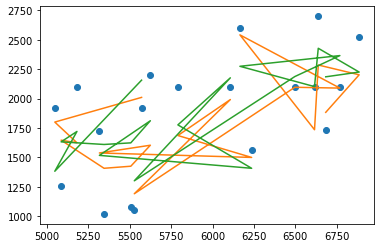

In [126]:
#Tentativa de Plotar 1 dimensão de feature x Y
import matplotlib.pyplot as plt
import numpy as np

plt.plot(x_plot,y_plot, 'o')
plt.plot(x_plot,y_poly)
plt.plot(x_plot,y_prediction)
plt.show()

